## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [13]:
# First few tagged sentences
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [14]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:5])

3718
196
[[('The', 'DET'), ('ultimate', 'ADJ'), ('result', 'NOUN'), ('came', 'VERB'), ('in', 'ADP'), ('Hymowitz', 'NOUN'), ('v.', 'CONJ'), ('Lilly', 'NOUN'), (',', '.'), ('where', 'ADV'), ('the', 'DET'), ('highest', 'ADJ'), ('New', 'NOUN'), ('York', 'NOUN'), ('court', 'NOUN'), ('expanded', 'VERB'), ('the', 'DET'), ('market-share', 'ADJ'), ('approach', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('first', 'ADJ'), ('time', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('say', 'VERB'), ('that', 'ADP'), ('drug', 'NOUN'), ('makers', 'NOUN'), ('that', 'DET'), ('*T*-1', 'X'), ('could', 'VERB'), ('prove', 'VERB'), ('0', 'X'), ('Mindy', 'NOUN'), ('Hymowitz', 'NOUN'), ("'s", 'PRT'), ('mother', 'NOUN'), ('did', 'VERB'), ("n't", 'ADV'), ('use', 'VERB'), ('their', 'PRON'), ('pill', 'NOUN'), ('must', 'VERB'), ('still', 'ADV'), ('pay', 'VERB'), ('their', 'PRON'), ('share', 'NOUN'), ('of', 'ADP'), ('any', 'DET'), ('damages', 'NOUN'), ('*T*-2', 'X'), ('.', '.')], [('Despite', 'ADP'), ('the', 'DET'), ('harsh', 'ADJ'

In [19]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95816

In [20]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['The',
 'ultimate',
 'result',
 'came',
 'in',
 'Hymowitz',
 'v.',
 'Lilly',
 ',',
 'where']

In [21]:
# vocabulary
V = set(tokens)
print(len(V))

12077


In [23]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [24]:
print(T)

{'DET', 'PRT', 'ADP', 'ADJ', 'X', 'NUM', 'NOUN', 'ADV', 'VERB', 'PRON', '.', 'CONJ'}


In [25]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [26]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [27]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [28]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [29]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [30]:
 tags_df

DET       PRT       ADP       ADJ         X       NUM      NOUN  \
DET   0.005430  0.000241  0.009049  0.205478  0.045729  0.022563  0.637548   
PRT   0.102985  0.001968  0.020663  0.084618  0.013775  0.056084  0.246638   
ADP   0.321254  0.001488  0.017216  0.106482  0.034219  0.062380  0.324867   
ADJ   0.004930  0.010682  0.078061  0.066557  0.021200  0.021364  0.697453   
X     0.055071  0.183622  0.146167  0.017458  0.074591  0.002698  0.060149   
NUM   0.002960  0.026643  0.035228  0.033748  0.209591  0.184133  0.354056   
NOUN  0.013265  0.043841  0.177077  0.011990  0.028863  0.009621  0.263593   
ADV   0.069536  0.013576  0.119205  0.128477  0.022517  0.032781  0.032119   
VERB  0.134325  0.031296  0.091641  0.064916  0.218840  0.022465  0.110156   
PRON  0.009199  0.012265  0.023764  0.073208  0.091223  0.007282  0.210042   
.     0.172574  0.002238  0.091031  0.044218  0.027658  0.080648  0.221625   
CONJ  0.119722  0.004640  0.052900  0.117401  0.008817  0.042227  0.348956   

           ADV      VERB      PRON         .      CONJ  
DET   0.012669  0.039937  0.003620  0.017254  0.000483  
PRT   0.010167  0.400459  0.017711  0.042637  0.002296  
ADP   0.013921  0.008608  0.069501  0.039426  0.000638  
ADJ   0.003944  0.012325  0.000493  0.066064  0.016927  
X     0.025551  0.205206  0.055388  0.163942  0.010157  
NUM   0.002368  0.018650  0.001184  0.118117  0.013321  
NOUN  0.017092  0.147012  0.004628  0.240452  0.042566  
ADV   0.079470  0.343046  0.015232  0.137417  0.006623  
VERB  0.081494  0.169029  0.035014  0.035169  0.005655  
PRON  0.034113  0.487543  0.007282  0.039095  0.004983  
.     0.052990  0.088167  0.066685  0.093806  0.058271  
CONJ  0.054756  0.155916  0.058469  0.035731  0.000464

In [31]:
tags_df.loc['.', :]

DET     0.172574
PRT     0.002238
ADP     0.091031
ADJ     0.044218
X       0.027658
NUM     0.080648
NOUN    0.221625
ADV     0.052990
VERB    0.088167
PRON    0.066685
.       0.093806
CONJ    0.058271
Name: ., dtype: float32

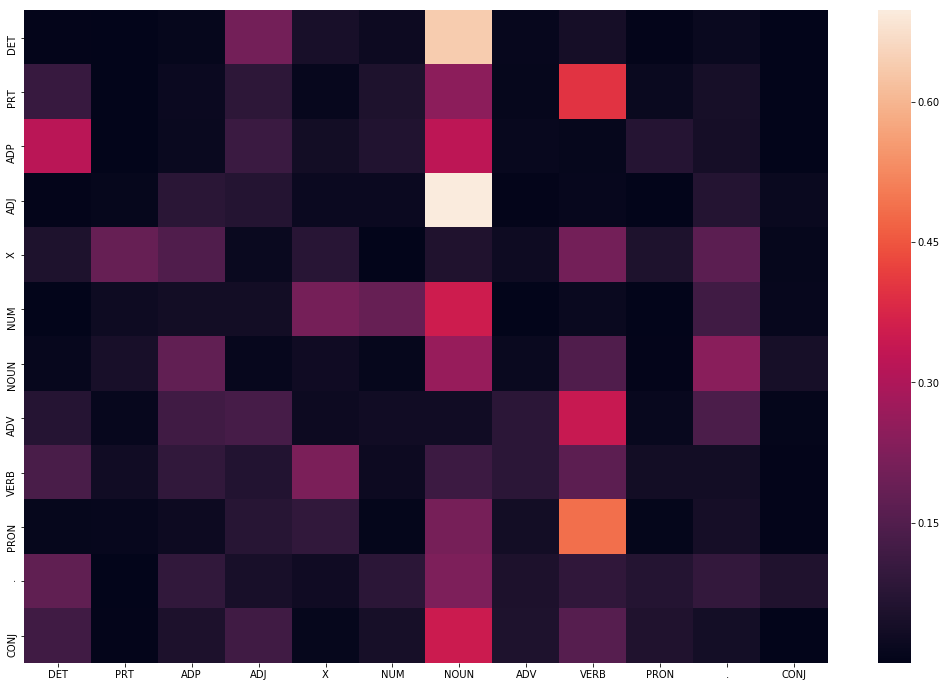

In [32]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

In [33]:
len(train_tagged_words)

95816

### Build the vanilla Viterbi based POS tagger

In [34]:
def Viterbi(words, train_bag = train_tagged_words,backoff=[]):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        e=[]
        t=[]
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]

            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            t.append(transition_p)
            e.append(emission_p) #Adding Emission prbability for all tag
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        state_max = None
        if pmax==0.0:
            linker=backoff.copy()
            while linker!=[]:
                if state_max==None:
                    state_max=linker.pop()([word])[0][1]
                else:
                    linker.clear()
            if state_max==None and backoff!=[]:
                if sum(e)==0.0:
                    state_max = T[t.index(max(t))]
        # getting state for which probability is maximum
        if state_max==None:
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [35]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 10 sents
rndom = [random.randint(1,len(test_set)) for x in range(10)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('The', 'DET'),
  ('company', 'NOUN'),
  ('noted', 'VERB'),
  ('that', 'ADP'),
  ('it', 'PRON'),
  ('has', 'VERB'),
  ('reduced', 'VERB'),
  ('debt', 'NOUN'),
  ('by', 'ADP'),
  ('$', '.'),
  ('1.6', 'NUM'),
  ('billion', 'NUM'),
  ('*U*', 'X'),
  ('since', 'ADP'),
  ('the', 'DET'),
  ('end', 'NOUN'),
  ('of', 'ADP'),
  ('1988', 'NUM'),
  ('and', 'CONJ'),
  ('bought', 'VERB'),
  ('back', 'PRT'),
  ('about', 'ADP'),
  ('15.5', 'NUM'),
  ('million', 'NUM'),
  ('shares', 'NOUN'),
  ('of', 'ADP'),
  ('common', 'ADJ'),
  ('stock', 'NOUN'),
  ('since', 'ADP'),
  ('the', 'DET'),
  ('fourth', 'ADJ'),
  ('quarter', 'NOUN'),
  ('of', 'ADP'),
  ('1987', 'NUM'),
  ('.', '.')],
 [('Hallwood', 'NOUN'),
  (',', '.'),
  ('a', 'DET'),
  ('Cleveland', 'NOUN'),
  ('merchant', 'NOUN'),
  ('bank', 'NOUN'),
  (',', '.'),
  ('owns', 'VERB'),
  ('about', 'PRT'),
  ('11', 'NUM'),
  ('%', 'NOUN'),
  ('of', 'ADP'),
  ('Integra', 'NOUN'),
  ('.', '.')],
 [('``', '.'),
  ('Markey', 'NOUN'),
  ('said', 'VERB'),
 

### Solve the problem of unknown words

In [36]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [37]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  43.831506967544556
[('The', 'DET'), ('company', 'NOUN'), ('noted', 'VERB'), ('that', 'ADP'), ('it', 'PRON'), ('has', 'VERB'), ('reduced', 'VERB'), ('debt', 'NOUN'), ('by', 'ADP'), ('$', '.'), ('1.6', 'NUM'), ('billion', 'NUM'), ('*U*', 'X'), ('since', 'ADP'), ('the', 'DET'), ('end', 'NOUN'), ('of', 'ADP'), ('1988', 'NUM'), ('and', 'CONJ'), ('bought', 'VERB'), ('back', 'ADV'), ('about', 'ADP'), ('15.5', 'DET'), ('million', 'NUM'), ('shares', 'NOUN'), ('of', 'ADP'), ('common', 'ADJ'), ('stock', 'NOUN'), ('since', 'ADP'), ('the', 'DET'), ('fourth', 'ADJ'), ('quarter', 'NOUN'), ('of', 'ADP'), ('1987', 'NUM'), ('.', '.'), ('Hallwood', 'NOUN'), (',', '.'), ('a', 'DET'), ('Cleveland', 'NOUN'), ('merchant', 'NOUN'), ('bank', 'NOUN'), (',', '.'), ('owns', 'VERB'), ('about', 'ADP'), ('11', 'NUM'), ('%', 'NOUN'), ('of', 'ADP'), ('Integra', 'NOUN'), ('.', '.'), ('``', '.'), ('Markey', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('we', 'PRON'), ('could', 'VERB'), ('have', 'VERB')

#### Evaluating tagging accuracy

In [38]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [39]:
accuracy = len(check)/len(tagged_seq)

In [40]:
accuracy

0.8798449612403101

In [41]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [42]:
print(incorrect_tagged_cases)

[[('bought', 'VERB'), (('back', 'ADV'), ('back', 'PRT'))], [('about', 'ADP'), (('15.5', 'DET'), ('15.5', 'NUM'))], [('owns', 'VERB'), (('about', 'ADP'), ('about', 'PRT'))], [('in', 'ADP'), (('public', 'ADJ'), ('public', 'NOUN'))], [('so', 'ADV'), (('little', 'ADJ'), ('little', 'ADV'))], [('little', 'ADV'), (('sensitive', 'DET'), ('sensitive', 'ADJ'))], [('disclosed', 'VERB'), (('*-132', 'DET'), ('*-132', 'X'))], [('The', 'DET'), (('prior-year', 'DET'), ('prior-year', 'ADJ'))], [('tax', 'NOUN'), (('adjustment', 'DET'), ('adjustment', 'NOUN'))], [('the', 'DET'), (('B-1B', 'NOUN'), ('B-1B', 'ADJ'))], [('B-1B', 'ADJ'), (('bomber', 'DET'), ('bomber', 'NOUN'))], [('industrial', 'ADJ'), (('sewing-machine', 'DET'), ('sewing-machine', 'NOUN'))], [('$', '.'), (('185.9', 'DET'), ('185.9', 'NUM'))], [('Your', 'PRON'), (('comments', 'VERB'), ('comments', 'NOUN'))], [('comments', 'NOUN'), (('implied', 'DET'), ('implied', 'VERB'))], [('``', '.'), (('principal', 'NOUN'), ('principal', 'ADJ'))], [('pri

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [43]:
### Applying Rule based tagger and Lexion tagger to solve the problem of unknown words
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger.evaluate(test_set)

0.9026748971193416

In [44]:
##Rule-Based (Regular Expression) Tagger
patterns = [
    (r'.*ing$', 'VERB'),              
    (r'.*ed$', 'VERB'),               
    (r'.*es$', 'VERB'),                     
    (r'.*\'s$', 'NOUN'),             
    (r'.*s$', 'NOUN'),               
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM')]

In [45]:
regexp_tagger = nltk.RegexpTagger(patterns)
# help(regexp_tagger)

In [46]:
regexp_tagger.evaluate(train_set)

0.12167070217917676

In [47]:
regexp_tagger.evaluate(test_set)

0.12530864197530864

In [48]:
# Combining Taggers
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

In [49]:
lexicon_tagger.evaluate(train_set)

0.9738143942556566

### Modified Vanilla Viterbi

In [61]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words, backoff=[lexicon_tagger]):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [103]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 10 sents
rndom = [random.randint(1,len(test_set)) for x in range(10)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('The', 'DET'),
  ('company', 'NOUN'),
  ('noted', 'VERB'),
  ('that', 'ADP'),
  ('it', 'PRON'),
  ('has', 'VERB'),
  ('reduced', 'VERB'),
  ('debt', 'NOUN'),
  ('by', 'ADP'),
  ('$', '.'),
  ('1.6', 'NUM'),
  ('billion', 'NUM'),
  ('*U*', 'X'),
  ('since', 'ADP'),
  ('the', 'DET'),
  ('end', 'NOUN'),
  ('of', 'ADP'),
  ('1988', 'NUM'),
  ('and', 'CONJ'),
  ('bought', 'VERB'),
  ('back', 'PRT'),
  ('about', 'ADP'),
  ('15.5', 'NUM'),
  ('million', 'NUM'),
  ('shares', 'NOUN'),
  ('of', 'ADP'),
  ('common', 'ADJ'),
  ('stock', 'NOUN'),
  ('since', 'ADP'),
  ('the', 'DET'),
  ('fourth', 'ADJ'),
  ('quarter', 'NOUN'),
  ('of', 'ADP'),
  ('1987', 'NUM'),
  ('.', '.')],
 [('Hallwood', 'NOUN'),
  (',', '.'),
  ('a', 'DET'),
  ('Cleveland', 'NOUN'),
  ('merchant', 'NOUN'),
  ('bank', 'NOUN'),
  (',', '.'),
  ('owns', 'VERB'),
  ('about', 'PRT'),
  ('11', 'NUM'),
  ('%', 'NOUN'),
  ('of', 'ADP'),
  ('Integra', 'NOUN'),
  ('.', '.')],
 [('``', '.'),
  ('Markey', 'NOUN'),
  ('said', 'VERB'),
 

In [104]:
tagged_seq = Viterbi(test_tagged_words, backoff=[lexicon_tagger])

In [107]:
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print(accuracy)
incorrect_tagged_cases = [j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

0.8798449612403101


In [110]:
accuracy = len(check)/len(tagged_seq)

In [111]:
accuracy

0.8798449612403101

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [117]:
print("Before {}, After {}".format(Viterbi(['sewing-machine']),Viterbi(['sewing-machine'],backoff=[lexicon_tagger])))

Before [('sewing-machine', 'DET')], After [('sewing-machine', 'DET')]


In [118]:
print("Before {}, After {}".format(Viterbi(['ambassador']),Viterbi(['ambassador'],backoff=[lexicon_tagger])))

Before [('ambassador', 'DET')], After [('ambassador', 'DET')]


In [119]:
print("Before {}, After {}".format(Viterbi(['tissue-transplant']),Viterbi(['tissue-transplant'],backoff=[lexicon_tagger])))

Before [('tissue-transplant', 'DET')], After [('tissue-transplant', 'DET')]
